In [1]:
# imports
import torch
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
#import wandb
#from prettytable import PrettyTable
import random
import os
from datetime import datetime
from torch.optim import lr_scheduler
import pandas as pd
from skimage import exposure

# local imports
#from models_parameters import losses
from utils import helper_functions
from utils.dataloader import Dataset as dataset
from utils.losses import calculate_metrics
from utils.convert import convert_image
import geopandas

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import torch.nn as nn

C:\Users\accou\anaconda3\envs\geo_env_n6\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [2]:
working_directory = "C:\\Users\\accou\\Documents\\GitHub\\a-PyTorch-Tutorial-to-Super-Resolution\\"
folder_path = "C:\\Users\\accou\\Documents\\thesis\\data_v2\\"
dataset_file = "C:\\Users\\accou\\Documents\\thesis\\data_v2\\final_dataset.pkl"
    
#filter_point=(367500.0,6822750.0) # Good one
#filter_point=(292500.0,6810750.0) # okay
#filter_point = (240750.0 , 6840000.0) # best one
filter_point="Area"
sen2_test_tile="all"

#from utils.dataloader_srcnn import Dataset as dataset

In [3]:
# normal
dataset_normal   = dataset(folder_path,dataset_file,test_train_val="test",transform="interpolate",sen2_amount=1, sen2_tile = sen2_test_tile,   location="local",filter_point=filter_point)
loader_normal = DataLoader(dataset_normal,batch_size=1, shuffle=False, num_workers=0,pin_memory=True,drop_last=False)

# standardize
dataset_stand   = dataset(folder_path,dataset_file,test_train_val="test",transform="standardize",sen2_amount=1, sen2_tile = sen2_test_tile,   location="local",filter_point=filter_point)
loader_stand = DataLoader(dataset_stand,batch_size=1, shuffle=False, num_workers=0,pin_memory=True,drop_last=False)

# moment matching
dataset_moment   = dataset(folder_path,dataset_file,test_train_val="test",transform="moment_matching",sen2_amount=1, sen2_tile = sen2_test_tile,   location="local",filter_point=filter_point)
loader_moment = DataLoader(dataset_moment,batch_size=1, shuffle=False, num_workers=0,pin_memory=True,drop_last=False)

#histogram_matching
dataset_hist   = dataset(folder_path,dataset_file,test_train_val="test",transform="histogram_matching",sen2_amount=1, sen2_tile = sen2_test_tile,   location="local",filter_point=filter_point)
loader_hist = DataLoader(dataset_hist,batch_size=1, shuffle=False, num_workers=0,pin_memory=True,drop_last=False)

filtering for inference Area
filtering for inference Area
filtering for inference Area
filtering for inference Area


In [4]:
def test_matching(loader):
    def Average(lst):
        return sum(lst) / len(lst)
    
    
    mae = nn.L1Loss()
    mse = nn.MSELoss()
    mae_ls = []
    mse_ls = []
    
    count=0
    for i in loader:
        count=count+1
        lr,hr,coor = i
        lr,hr = lr.to(device),hr.to(device)
        mae_ls.append(mae(lr,hr).item())
        mse_ls.append(mse(lr,hr).item())
        if count%100==0:
            print(count,"/",len(loader),end="\r")
    return(Average(mae_ls),Average(mse_ls))
        

In [5]:
mae_normal,mse_normal = test_matching(loader_normal)
print("Normal finished.")
mae_stand,mse_stand = test_matching(loader_stand)
print("Stand finished.")
mae_moment,mse_moment = test_matching(loader_moment)
print("Moment finished.")
mae_hist,mse_hist = test_matching(loader_hist)
print("Hist finished.")


Normal finished.
Stand finished.
Moment finished.
Hist finished.


In [19]:
res = [ [mae_normal, mse_normal], 
                 [mae_stand,mse_stand ], 
                 [mae_moment, mse_moment], 
                 [mae_hist, mse_hist], ]

column_names=["MAE","MSE"]
row_label=["No Matching","Standardization","Moment Matching","Histogram Matching"]

df=pd.DataFrame(res,columns=column_names,index=row_label)
del res
# _________________________________________________________________________________________________________
res = [ [mae_normal, mse_normal], [mae_stand,mse_stand ]]

column_names=["MAE","MSE"]
row_label=["No Matching","Standardization"]

df1=pd.DataFrame(res,columns=column_names,index=row_label)
del res
# _________________________________________________________________________________________________________

res = [  [mae_moment, mse_moment], 
                 [mae_hist, mse_hist], ]

column_names=["MAE","MSE"]
row_label=["Moment Matching","Histogram Matching"]

df2=pd.DataFrame(res,columns=column_names,index=row_label)
del res

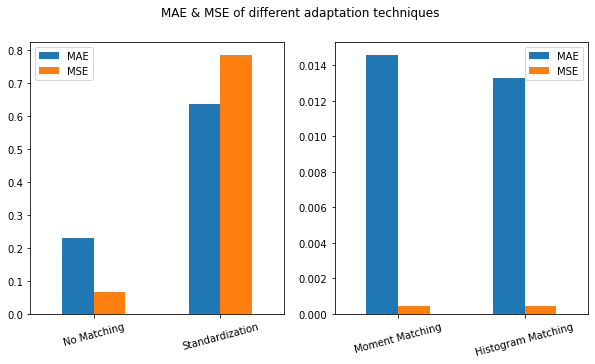

In [38]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
#pd1.plot(ax = axes[0,0], subplots=True) 
#pd2.plot(ax = axes[0,1], subplots=True)


df1.plot.bar(stacked=False,rot=15,ax = axes[0])
df2.plot.bar(stacked=False,rot=15,ax = axes[1])
fig.suptitle("MAE & MSE of different adaptation techniques")
plt.savefig("adaptations.png")
plt.show()

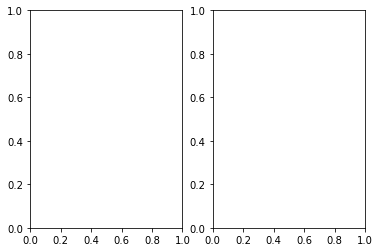

In [29]:
fig, axes = plt.subplots(nrows=1,ncols=2)